# Preprocessing


Fluorescence datasets ideally reflect a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing. 

Today, we will define the ROIs (regions of interest) in this set of images. You may have noticed some qualities of the above images that make them hard to reliably threshold into masks relecting the relevant cell organelles.

Part 1 Getting Ready
1. Loading images
2. Metadata
3. Visual inspection


Part 2: Global Threshold
1. Difference in intensity between images.
    - Introduction to automated thresholding methods.

Part 3: Local Threshold
1. Noise corrupting the images
    - Introduction to Rank Filters: median filter
2. Uneven illumination in the nucleus channel makes finding a single threshold across a single image challenging. 
    - Rolling ball background subtraction
3. Uneven paxillin expression, low EGFP signal, and cytoplasmic signal complicate focal adhesion thresholding
    - thresholding within defined ROIs 

First, let's import packages.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import skimage


sns.set_style('dark', rc={'image.cmap':'inferno'})

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


First, check files in the directory.

In [3]:
data_path = "../Data/Data_ConfocalDrugPanel/"
import os
os.listdir(data_path)

['.ipynb_checkpoints',
 'DMSO.tif',
 'DMSO_metadata.json',
 'drugA.tif',
 'drugA_metadata.json',
 'NewLesson2_Preprocessing.ipynb',
 'temp_DMSO.tif']

Then, read files of interest, in our case, dataset with and without drug. Check dimensions of the dataset.

In [4]:
from skimage.io import imread

data_drug = np.uint16(imread(data_path + "drugA.tif")) #treated with drugA
data_nodrug = np.uint16(imread(data_path + "DMSO.tif")) #treated without drug

In [5]:
data_drug.shape

(10, 819, 819, 3)

Let's examine the metadata- json is the format for this dataset.

In [7]:
import json
with open(data_path+'DMSO_metadata.json', mode='r') as f_nodrug:
    meta_nodrug = json.load(f_nodrug)

In [8]:
meta_nodrug 
#or more nicely, 
#for key, value in meta_nodrug.items():
#    print(key)

{'axes': ['ZXYTC'],
 'pixel_size': [0.3459442, 0.3459442, 0.7694383],
 'cell_type': 'fibroblast',
 'channels': ['your_fav_protein', 'nucleus', 'actin'],
 'raw_data_date': ['add_this'],
 'image_preprocessing_done': ['Noise_generator.ipynb',
  'Branch=day3-day4-rework',
  "GitCommitId=b'8669e48fb072e2f87f655b3e87f09e4926dbf1b0\\n'"]}

Let's re-label the slices with names, instead of numbers.

In [9]:
drug_slice = {}
nodrug_slice = {}
for idx, channel in enumerate(meta_nodrug['channels']):
    drug_slice[channel] = data_drug[3,:,:,idx]
    nodrug_slice[channel] = data_nodrug[3,:,:,idx] #add in the indexing when read in full dataset
    print(channel)

your_fav_protein
nucleus
actin


We are ready to plot and visualize our dataset! We can see there is a change before drug vs after drug.

Text(0.5, 0.98, 'After Drug')

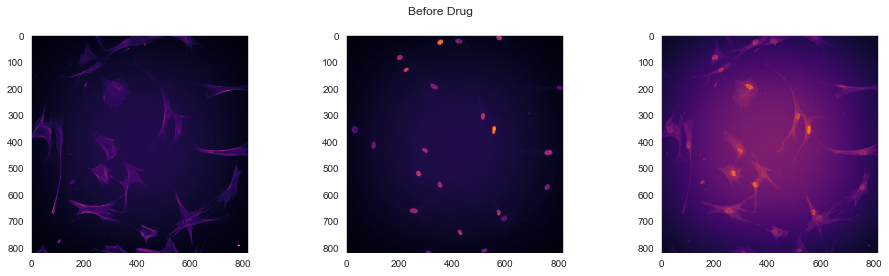

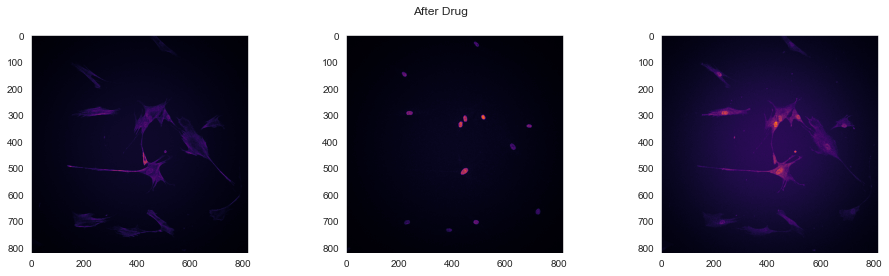

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(nodrug_slice["actin"])
ax[1].imshow(nodrug_slice['nucleus'])
ax[2].imshow(nodrug_slice["your_fav_protein"])
fig.suptitle('Before Drug')

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(drug_slice["actin"])
ax[1].imshow(drug_slice['nucleus'])
ax[2].imshow(drug_slice["your_fav_protein"])
fig.suptitle('After Drug')

Now, let's start pre-processing our dataset. We will focus on the "your_fav_protein" dataset.

In [11]:
data1 = nodrug_slice["your_fav_protein"]
data2 = drug_slice["your_fav_protein"]

First, let's try global threshold, selecting one, single value for the entire data set. The widget allows to change the value manually.

In [12]:
#data1 = vinc["nucleus"]
#data2 = wt["nucleus"]

from ipywidgets import interactive
@interactive
def show_masks(thresh=(0, data1.max() * 0.3, 500)): #shwo_masks a function, whey thresh have 3 input
    fig, ax = plt.subplots(1, 2, figsize=(64, 50))
    
    mask1 = np.zeros(data1.shape)
    mask2 = np.zeros(data2.shape)
    
    mask1[data1 >=thresh] = 1
    mask2[data2 >=thresh] = 1
    
    ax[0].imshow(mask1, vmin=0, vmax=1)
    ax[1].imshow(mask2, vmin=0, vmax=1)
show_masks

interactive(children=(FloatSlider(value=3500.0, description='thresh', max=7514.7, step=500.0), Output()), _dom…

It looks like thresholding fails- a ring like structure is visible. There might be an uneven illumination and other noises in the dataset. Let's filter out these noises. Here's our raw data: can you see some of noises? Speckles are visible. Let's remove these 'salt-and-pepper' noise first.

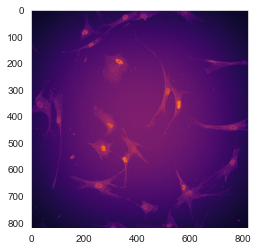

In [13]:
plt.imshow(nodrug_slice["your_fav_protein"])

We need to import packages and filters. (Please refer to the background slides for the introduction to filters)

In [14]:
from skimage.filters.rank import mean as mean_filter
from skimage.filters.rank import minimum as min_filter
from skimage.filters.rank import maximum as max_filter
from skimage.filters.rank import median as median_filter
from skimage.morphology import disk

First, let's examine the effect of filter sizes.

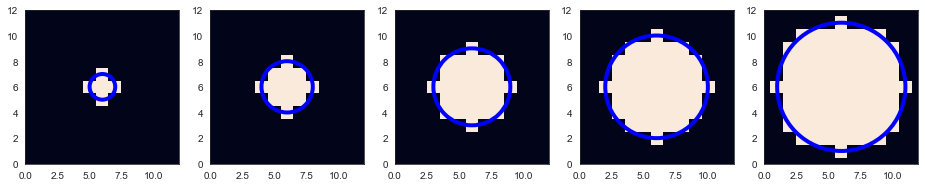

In [15]:
from skimage.morphology import disk

with sns.axes_style('white'):
    N = 5
    fig, axes = plt.subplots(1, N, figsize=(16, 3))
    for n, ax in enumerate(axes):
        np1 = n + 1
        ax.imshow(np.pad(disk(np1), N-n, 'constant'), interpolation='none')
        c = plt.Circle((np1 + N - n, np1 + N - n), radius=np1, fill=False, lw=4, color='b')
        ax.add_artist(c)
        ax.set_xlim(0, 2 * N + 2)
        ax.set_ylim(0, 2 * N + 2)

Now, try using median filter to remove the salt-pepper noise. Can you see differences in the images?

In [1]:
f_size = 1
data_filt = median_filter(nodrug_slice["your_fav_protein"], disk(f_size))

max_view = 2000 #change me to change brightness of all images uniformly

fig, ax = plt.subplots(1, 2)#, figsize=
ax[0].imshow(nodrug_slice["your_fav_protein"])
ax[1].imshow(data_filt)
fig.suptitle('Median Filter')
nodrug_slice["your_fav_protein"]
# fig, ax = plt.subplots(2, 2, figsize=(20, 20))
# ax[0, 0].imshow(data_noised, interpolation = 'none', vmin = 0, vmax = max_view)
# ax[0, 1].imshow(data_filt, interpolation = 'none', vmin = 0, vmax = max_view)
# ax[1, 0].imshow(vinc['pax'], interpolation = 'none', vmin = 0, vmax = max_view)
# ax[1, 1].imshow(im_filt, interpolation = 'none', vmin = 0, vmax = max_view)

NameError: name 'median_filter' is not defined

<Exercise: try median filter with nucleus dataset. Also try minimum filter.>

Now, we can take the filtered image and further pre-process. We'd like to remove the un-even illumination. First, we will extract the background. The radius should be set to at least the size of the largest object that is not part of the background.

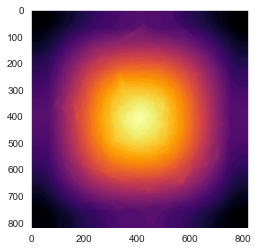

In [32]:
# the radius should be set to at least the size of the largest object that is not part of the background
r = 70
structuring_element = disk(r)
background = min_filter(data_filt, structuring_element)
plt.imshow(background, cmap='inferno', interpolation = 'none')#, vmin = 0, vmax = 3000)

Next, let's substract out the background from the dataset.

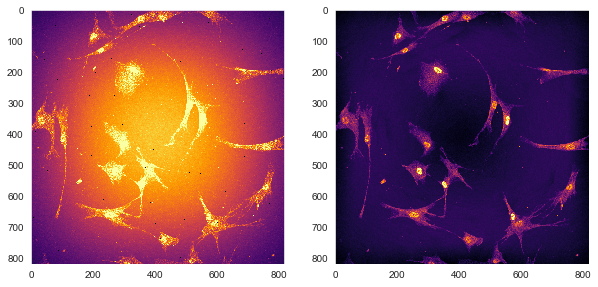

In [33]:
bgs = data_filt - background
bgs[bgs<0] = 0


max_val_see = 10000

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(nodrug_slice["your_fav_protein"], interpolation = 'none', vmax = max_val_see)
ax[1].imshow(bgs, interpolation = 'none', vmax = max_val_see)

With our pre-processed dataset, let's try the thresholding again.

In [19]:
#data1 = vinc["nucleus"]
#data2 = wt["nucleus"]

from ipywidgets import interactive
@interactive
def show_masks(thresh=(0, data1.max() * 0.3, 500)): #shwo_masks a function, whey thresh have 3 input
    fig, ax = plt.subplots(1, 2, figsize=(64, 50))
    
    mask1 = np.zeros(data1.shape)
    mask2 = np.zeros(data2.shape)
    
    mask1[data1 >=thresh] = 1
    mask2[data2 >=thresh] = 1
    
    ax[0].imshow(mask1, vmin=0, vmax=1)
    ax[1].imshow(mask2, vmin=0, vmax=1)
show_masks

interactive(children=(FloatSlider(value=3500.0, description='thresh', max=7514.7, step=500.0), Output()), _dom…

While manual thresholding is convenient, it is not the most reliable way to decide the threshold. How can we systematically and reproducibly define a threshold? Otsu's method looks at the histogram and differentiate "signal" vs "noise" to determine the threshold. We want a value that includes signal only. (please see the slides for more information)

First, we will define a mask function. When a data point is greater than threshold, we will give 1. Otherwise 0.

In [34]:
#answer
def mask_im(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    plt.imshow(mask, vmin = 0, vmax = 1)
    return(mask)

Let's use otsu filter from the imported packages.

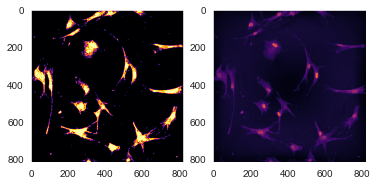

In [35]:
#answer:
from skimage.filters import threshold_otsu

data = bgs.copy()
thresh = threshold_otsu(data)
mask = mask_im(data,thresh) #mask_im 
plt.close('all')  # mask_im produces an image of mask, close it for now
fig, ax = plt.subplots(1, 2) #, figsize=(32, 50)) 
ax[0].imshow(mask)#[700:900, :200])
ax[1].imshow(data)#[700:900, :200])

Let's examine what Otsu's method did by looking at the histogram. We can see signal cluster vs noise cluster and the threshold value.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


(0.0, 300000.0)

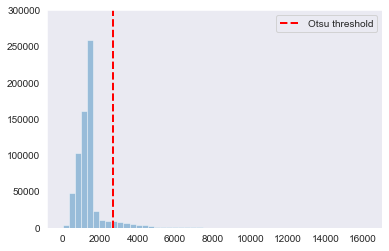

In [36]:
#answer
sns.distplot(data.flatten(), hist_kws={'log': False}, kde=False) 
plt.axvline(thresh, ls='--', lw=2, c='r', label='Otsu threshold') 
plt.legend()
plt.ylim(0,300000)

We can also extract the threshold value.

In [37]:
#answer
protein_thresh = threshold_otsu(data) 
print("The calculated masking threshold for the fav_protein is:", protein_thresh)

The calculated masking threshold for the fav_protein is: 2702


Exercise: try Otsu's method with the filtered nucleus dataset.

Otsu's method isn't the only way to determine the threshold. A list of various methods are listed here: https://imagej.net/Auto_Threshold Another example is Yen's method, a multi-level thresholding algorithm.

667


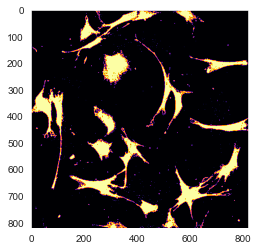

In [38]:
import skimage.filters as filters
from skimage.morphology import label
protein_mask = mask_im(data, filters.threshold_yen(data)) 
#plt.imshow(label(nuc_mask))
print(label(protein_mask).max()) 

Let's examine istogram for Yen's method.

In [39]:
from skimage.filters import threshold_yen
protein_thresh_yen = threshold_yen(data) 
print("The calculated masking threshold for the fav_protein is:", protein_thresh)

The calculated masking threshold for the fav_protein is: 2702


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


(0.0, 300000.0)

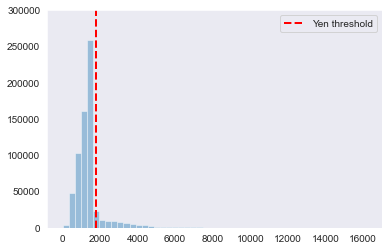

In [40]:
sns.distplot(data.flatten(), hist_kws={'log': False}, kde=False) 
plt.axvline(protein_thresh_yen, ls='--', lw=2, c='r', label='Yen threshold') 
plt.legend()
plt.ylim(0,300000)

It's the end of this course. We only mentioned global thresholds, but local thresholding is also possible where threshold varies within a dataset.

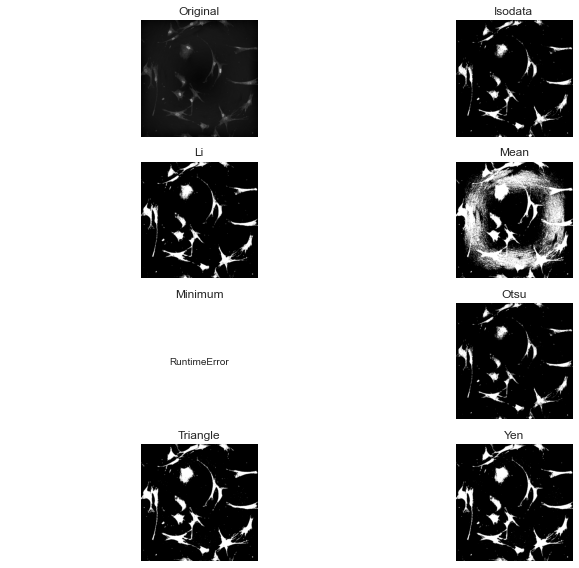

In [47]:
from skimage.filters import try_all_threshold


fig, ax = try_all_threshold(data, figsize=(10, 8), verbose=False)
plt.show()
